In [35]:
# Importing necessary libraries
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

In [36]:

# Step 1: Data Loading and Preprocessing
file_path = r"C:\Users\Thanay kumar\Documents\Project\Tata Stock .csv"
dataset_train = pd.read_csv(file_path)

# Using relevant columns from the dataset
training_set = dataset_train[['Open', 'High', 'Low', 'Close']].values

# Normalizing the data
sc = MinMaxScaler(feature_range=(0, 1))
training_set_scaled = sc.fit_transform(training_set)

In [37]:
# Step 2: Preparing Training Data
X_train = []
y_train = []
for i in range(100, len(training_set_scaled)):
    X_train.append(training_set_scaled[i-100:i])  # 100 time steps back
    y_train.append(training_set_scaled[i, 0])  # Predict 'Open' price

X_train, y_train = np.array(X_train), np.array(y_train)

# Reshaping data for LSTM model
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 4))  # 4 features (Open, High, Low, Close)

In [ ]:
# Step 3: Building and Compiling the Model
model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(LSTM(units=100))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(units=1))  # Output layer

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
# Step 4: Training the Model
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

model.fit(X_train, y_train, epochs=200, batch_size=32, validation_split=0.2, callbacks=[early_stopping, reduce_lr])

In [ ]:
#Step 5: Preparing Testing Data

#Load the test dataset
dataset_test = pd.read_csv(r"C:\Users\Thanay kumar\Documents\Project\Tatatest.csv")  # Load the test data
real_stock_price = dataset_test.iloc[:, 1:2].values  # Extract the 'Open' price from the test data

# Concatenate training and test data
dataset_total = pd.concat((dataset_train[['Open', 'High', 'Low', 'Close']], dataset_test[['Open', 'High', 'Low', 'Close']]), axis=0)

# Prepare the test inputs for prediction
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 120:].values
inputs = inputs.reshape(-1, 4)  # Ensure we have 4 features
inputs = sc.transform(inputs)  # Apply scaling



In [ ]:
#Step 6: Making Predictions

# Prepare the test data (X_test)
X_test = []
for i in range(120, 120 + len(dataset_test)):
    X_test.append(inputs[i-100:i])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 4))  # 4 features per time step

# Predict the stock prices
predicted_stock_price = model.predict(X_test)

# Reshape predictions for inverse transformation
predicted_stock_price = predicted_stock_price.reshape(-1, 1)

# Add dummy columns to match the scaler's expectation
dummy_columns = np.zeros((predicted_stock_price.shape[0], 3))  # Create 3 dummy columns
predicted_stock_price_with_dummy = np.concatenate((predicted_stock_price, dummy_columns), axis=1)

# Inverse transform the predictions
predicted_stock_price = sc.inverse_transform(predicted_stock_price_with_dummy)

# Extract the predicted 'Open' price (first column)
predicted_stock_price = predicted_stock_price[:, 0]


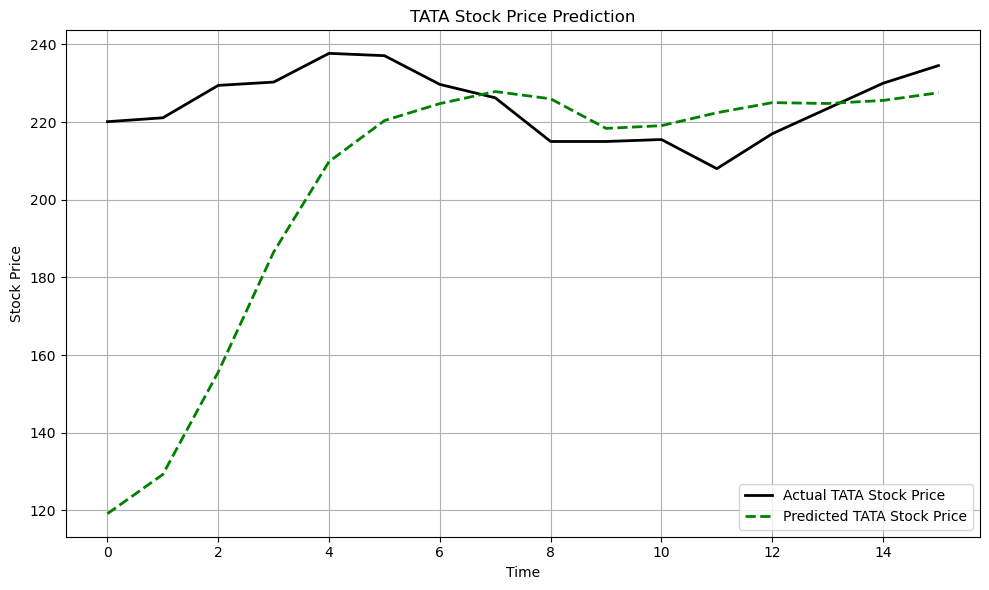

Root Mean Squared Error (RMSE): 41.51
R² Score: -22.4768


In [62]:
# Step 7: Plotting and Evaluating the Model
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Plotting actual vs predicted stock prices
plt.figure(figsize=(10, 6))
plt.plot(real_stock_price, color='black', label='Actual TATA Stock Price', linewidth=2)
plt.plot(predicted_stock_price, color='green', linestyle='--', label='Predicted TATA Stock Price', linewidth=2)
plt.title('TATA Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Save the plot as a high-res image
plt.savefig("tata_stock_prediction.png", dpi=300)
plt.show()

# Evaluate model performance
rmse = np.sqrt(mean_squared_error(real_stock_price, predicted_stock_price))
r2 = r2_score(real_stock_price, predicted_stock_price)
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.4f}")
